# Lecture 1

In [1]:
#lazy-import all the numpy and matplotlib stuff you need
%pylab inline

#some more imports
import os
cwd = os.getcwd()
from os.path import join as pj
from PIL import Image

Populating the interactive namespace from numpy and matplotlib


## Natural Images

First load a natural image displaying the Tuebingen Neckarfront.

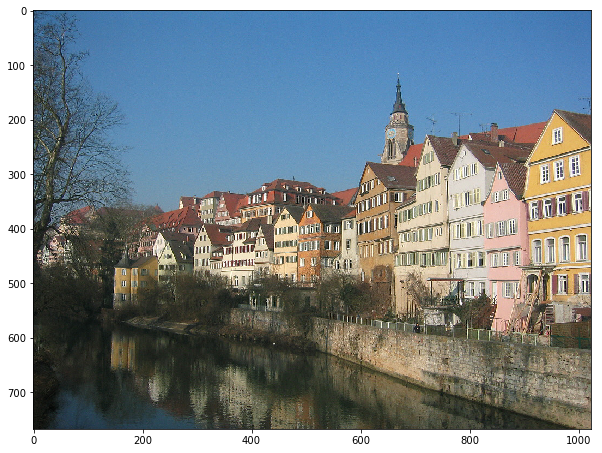

In [2]:
img_name = 'Tuebingen_Neckarfront.jpg'
img = Image.open(pj(cwd, img_name))
imshow(img); gcf().set_size_inches(10,10)

Natural Images have complex statistical dependencies between the individual pixels. <br>
Let's destroy these dependencies by randomly shuffeling each colour pixel to a new position.<br> 
We will see that the resulting image looks nothing like a natural image anymore.

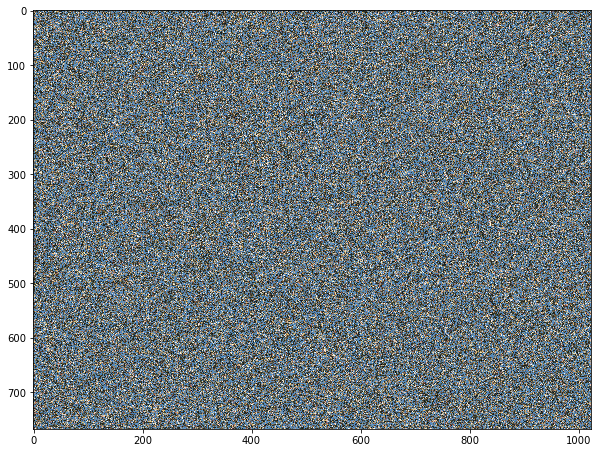

In [3]:
#get the pixel values in a floating point numpy array with values between 0. and 1.
img_data = array(img) / 255.
h,w,c = img_data.shape

#make random image by randomly permuting the colour pixels
rnd_ndx = permutation(h*w)
img_rnd = img_data.reshape(h*w, c)[rnd_ndx, :].reshape(img_data.shape)
imshow(img_rnd)
gcf().set_size_inches(10,10)

Now what are the statistical dependencies between pixels in natural images? <br>
Above we destroyed all dependencies by shuffeling. We can also destroy all dependencies apart from the pair-wise correlations between pixels using a technique called phase-scrambling of the image. <br>
The idea is that we will preserve the power spectrum of the image but combine it with a random phase spectrum in fourier space. Because the power spectrum is equivalent to the auto-correlation function (see Wiener Khinchin Theorem), this preserves the pair-wise correlations between all pixels but destroys all other structure in the image.


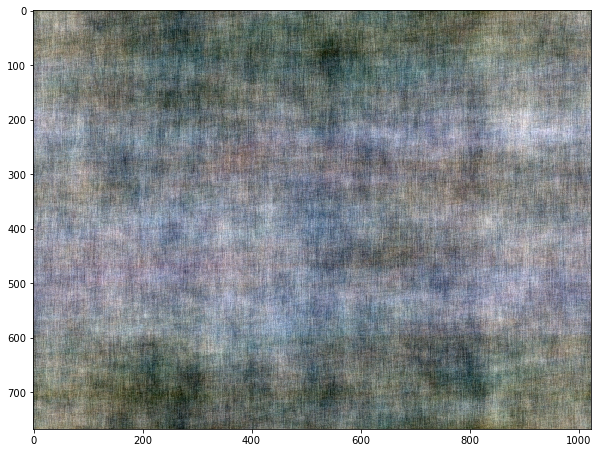

In [4]:
#make phase-scrambled image, which preserves the pairwise pixel correlations
img_phs = zeros_like(img_data)
#get a random phase spectrum
aft = angle(fft2(rand(*img_data[:, :, 0].shape)))
#combine the power spectrum of each colour channel with the same random phase spectrum
for i in range(c):
    ft = abs(fft2(img_data[:, :, i]))
    img_phs[:, :, i] = real(ifft2(ft * exp(1j*aft)))
#recast the pixels to the range [0,1] to display
img_phs -= img_phs.min()
img_phs /= img_phs.max()
imshow(img_phs)
gcf().set_size_inches(10,10)

Although this image is clearly more similar to a natural image than the randomly shuffled image, it still is not a natural image. <br>
That means, that the statistical structure of natural images is not captured by the simple correlations between pairs of pixels, but rather by more complex dependencies between larger numbers of pixels. <br>
Thus, to model natural images we ideally want to know about the causal factors of the world, such as objects or lighting conditions, that give rise to the complex structure on the pixel level. <br>
A class of models that excell at extraction object information from natural images are Convolutional Neural Networks (CNN). Below we use a CNN that was trained to perform object recognition to classify the image of Tuebingen.

## Convolutional Neural Networks

Unlike in the lecture where we used AlexNet, we will use Squeezenet here, which has the same performance but is vastly smaller and thus easier to distribute to you.<br>
If you want, you can read more about Squeezenet here: https://arxiv.org/abs/1602.07360

In [5]:
import torch
import torchvision.models as models

squeezenet = models.squeezenet1_0()
squeezenet_weights = torch.load('../squeezenet1_0-a815701f.pth')
squeezenet.load_state_dict(squeezenet_weights)
#set the network to evaluation mode to disable Dropout
squeezenet.eval();

ImportError: /home/andrii/anaconda3/lib/python3.6/site-packages/torch/_C.cpython-36m-x86_64-linux-gnu.so: undefined symbol: PySlice_Unpack

In [6]:
#show model architecture - this is a little more complex than alexnet
squeezenet

SqueezeNet (
  (features): Sequential (
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Fire (
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (4): Fire (
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU (inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU (inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU (inplace)
    )
    (5): Fire (
      (squeeze): Conv2d(128, 32, kernel_size

In [11]:
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F

# define pre and post processing for images
img_size = 224
prep = transforms.Compose([
        transforms.Scale((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

postp = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0],
                             std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                             std=[1,1,1]),
        transforms.ToPILImage(),
    ])


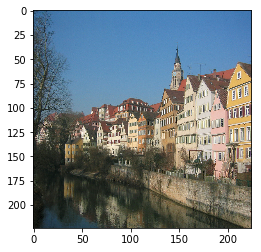

In [12]:
#preprocess image
img_torch = Variable(prep(img).unsqueeze(0), volatile=True)
#show preprocessed image, dimensions are now 224x224 since this is what the network was trained on
imshow(postp(img_torch.data.squeeze()))

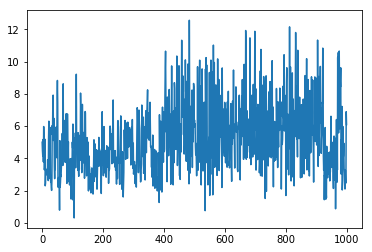

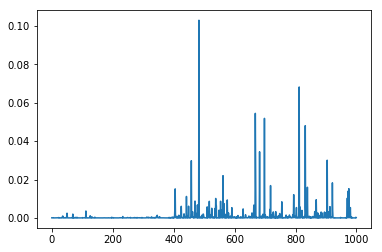

In [13]:
#run image through the network
out = squeezenet(img_torch)

#show classification before softmax
plot(out.data.numpy().squeeze());show()

#show classification after softmax
out = F.softmax(out)
plot(out.data.numpy().squeeze());show()

out_data = out.data.numpy().squeeze()

In [14]:
#load the list of object labels of the ImageNet Dataset that the network was trained on.
with open('synset_words.txt') as syn:
    class_labels = syn.readlines() 
class_labels = [label.split(' ', 1)[1].split('\n')[0] for label in class_labels]

In [15]:
#show the top5 predictions for the Tuebingen image
[(i+1,class_labels[o], 'probability: %.2f'%(out_data[o])) for i,o in enumerate(out_data.argsort()[-5:][::-1])]

[(1, 'castle', 'probability: 0.10'),
 (2, 'space shuttle', 'probability: 0.07'),
 (3, 'mosque', 'probability: 0.05'),
 (4, 'palace', 'probability: 0.05'),
 (5, 'stupa, tope', 'probability: 0.05')]

looks like in difference to alexnex, squeezenet doesn't see candles anymore ;-)